# **Law of Motion Calculations**

#### Libraries

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
import pandas as pd
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [1]:
plt.rcParams['font.family'] = 'serif'

NameError: name 'plt' is not defined

#### **Data Setup**

In [2]:
#Load Megamerged
Mega_merged = pd.read_csv('LEX_DEX_Cases_MegaMerged_vf.csv')
Mega_merged.iloc[:,2] = pd.to_datetime(Mega_merged.iloc[:,2])
Mega_merged.dtypes
split_date = pd.datetime(2020,8,1)
Mega_merged_early = Mega_merged.loc[Mega_merged['date'] < split_date]
Mega_merged.drop(Mega_merged.columns[0], axis=1, inplace = True)
covid_date = pd.datetime(2020,3,20)
Mega_merged["CovidTime"] =  np.where(Mega_merged['date'] < covid_date, 0, 1)
def strip(s):
    string = str(s)
    if len(string) == 5:
        return int(string[0:2])
    elif len(string) == 4:
        return int(string[0])
    
Mega_merged['state'] = Mega_merged['county'].apply(strip)
Mega_merged.loc[Mega_merged['Year']==2021, 'Week'] = Mega_merged['Week'] + 52
Mega_merged.head()

<ipython-input-2-85e6e0943ffe>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2020,8,1)
<ipython-input-2-85e6e0943ffe>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  covid_date = pd.datetime(2020,3,20)


,county,date,dex,num_devices,Cases_x,aggLEX,Diff,Dex14DaysAgo,DEX11,DEX8,DEX5,Weekday,Week,Year,CovidTime,state
0,1001,2020-01-25,285.1728,5835,0,0.523581,0,285.1728,NaN,NaN,NaN,7,4,2020,0,1
1,1001,2020-01-29,126.1026,5753,0,0.506453,0,126.1026,NaN,NaN,285.1728,4,5,2020,0,1
2,1001,2020-02-01,337.6171,5895,0,0.529369,0,337.6171,NaN,285.1728,126.1026,7,5,2020,0,1
3,1001,2020-02-05,119.4391,5915,0,0.509230,0,119.4391,285.1728,126.1026,337.6171,4,6,2020,0,1
4,1001,2020-02-08,332.3768,5947,0,0.529436,0,285.1728,126.1026,337.6171,119.4391,7,6,2020,0,1


Transform to a weekly basis

In [3]:
df = Mega_merged.groupby(['county', 'Year', 'Week']).mean().reset_index()
df['DEX7'] = df['dex'].shift(periods=1)
df.sample(10)

,county,Year,Week,dex,num_devices,Cases_x,aggLEX,Diff,Dex14DaysAgo,Weekday,CovidTime,state,DEX7
2036,1055,2020,24,169.37245,8520.5,304.5,0.485712,27.5,136.16485,5.5,1.0,1.0,161.79350
116247,40087,2021,78,349.03560,3203.5,5344.0,0.550349,5.0,349.37815,5.5,1.0,40.0,384.07820
20907,12087,2021,78,219.96055,7354.0,7196.0,0.515854,23.0,202.21730,5.5,1.0,12.0,214.49385
12541,6065,2020,29,73.20750,90148.5,29384.0,0.412335,2128.5,67.66610,5.5,1.0,6.0,79.84365
56860,21089,2021,79,154.43030,1838.5,3724.5,0.529775,8.0,183.54685,5.5,1.0,21.0,147.44030
20937,12089,2020,25,163.90085,7300.0,103.5,0.510146,10.5,146.83585,5.5,1.0,12.0,147.29515
128801,45071,2020,33,138.64485,2640.0,881.5,0.525364,24.5,116.27785,5.5,1.0,45.0,127.19810
33214,16045,2020,38,85.94085,877.5,269.5,0.512753,3.5,67.29430,5.5,1.0,16.0,81.71305
10822,6015,2021,73,52.76395,758.5,1383.0,0.485502,11.0,55.18840,5.5,1.0,6.0,47.63815
123446,42075,2021,53,141.82230,3658.0,9087.0,0.500507,371.0,169.87480,7.0,1.0,42.0,90.30920


In [4]:
#Create Periodic Dataframes WEEKLY CONDENSED

TwentyTwenty = df.loc[df['Year'] == 2020]
TwentyTwentyOne = df.loc[df['Year'] == 2021]
TwentyTwenty.head()

,county,Year,Week,dex,num_devices,Cases_x,aggLEX,Diff,Dex14DaysAgo,Weekday,CovidTime,state,DEX7
0,1001,2020,4,285.17280,5835.0,0.0,0.523581,0.0,285.17280,7.0,0.0,1.0,NaN
1,1001,2020,5,231.85985,5824.0,0.0,0.517911,0.0,231.85985,5.5,0.0,1.0,285.17280
2,1001,2020,6,225.90795,5931.0,0.0,0.519333,0.0,202.30595,5.5,0.0,1.0,231.85985
3,1001,2020,7,241.50980,5885.5,0.0,0.519852,0.0,231.85985,5.5,0.0,1.0,225.90795
4,1001,2020,8,221.59240,5814.0,0.0,0.520375,0.0,225.90795,5.5,0.0,1.0,241.50980


## **LSTM Implementation**

Data Standardization

In [5]:
# normalize the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.drop(columns=['county','Year','Week', 'CovidTime', 'state', 'Diff']))
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled,columns=df.drop(columns=['county','Year','Week', 'CovidTime', 'state', 'Diff']).columns)

In [6]:
confirmed_Cases=df.copy()
confirmed_Cases[scaled_df.columns]=np.array(scaled_df)
confirmed_Cases['county_name']=list(confirmed_Cases.county)

In [7]:
confirmed_Cases=confirmed_Cases.set_index(['county','Week'])
confirmed_Cases = confirmed_Cases.drop(columns=['Cases_x', 'Year','num_devices', 'aggLEX', 'dex', 'Weekday', 'state'])
confirmed_Cases.head(10)

Diff  Dex14DaysAgo  CovidTime      DEX7  county_name
county Week                                                      
1001   4      0.0      0.254503        0.0       NaN         1001
       5      0.0      0.206217        0.0  0.275522         1001
       6      0.0      0.179450        0.0  0.223248         1001
       7      0.0      0.206217        0.0  0.217413         1001
       8      0.0      0.200827        0.0  0.232710         1001
       9      0.0      0.214957        0.0  0.213181         1001
       10     0.0      0.196918        0.0  0.265679         1001
       11     0.0      0.245411        0.0  0.224632         1001
       12     0.0      0.207495        0.5  0.198949         1001
       13     3.0      0.183772        1.0  0.091551         1001

Test Train Split

In [8]:
# Because this is panel data so I will split each country_Region's data 
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['Diff']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['Diff']).iloc[size:]
    y_train=data['Diff'].iloc[0:size] 
    y_test=data['Diff'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [9]:
county=list(set(confirmed_Cases.county_name))
# loop each county and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(county)):
    data=confirmed_Cases[confirmed_Cases['county_name']==county[i]]
    # applied the function I created above
    x_train, x_test,y_train,y_test=train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [10]:
X_train[0].head()

Dex14DaysAgo  CovidTime      DEX7  county_name
county Week                                                
41003  4         0.046370        0.0  0.141034        41003
       5         0.053129        0.0  0.050200        41003
       6         0.046370        0.0  0.057516        41003
       7         0.053129        0.0  0.059082        41003
       8         0.054575        0.0  0.055834        41003

In [11]:
Y_train[0].head()

county  Week
41003   4       0.0
        5       0.0
        6       0.0
        7       0.0
        8       0.0
Name: Diff, dtype: float64

In [12]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [13]:
Y_test.head()

Diff
county Week      
41003  70    47.0
       71    54.5
       72    45.5
       73    20.0
       74    17.5

In [14]:
X_train.shape

(135206, 4)

Data Preprocessing

In [15]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [16]:
encoder = LabelEncoder()
#combine X train and Y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
#train_data['county']= encoder.fit_transform(train_data['county_name'])
#combine X test and Y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
#test_data['county']= encoder.fit_transform(test_data['county_name'])

In [17]:
train_data.sample()

,,Dex14DaysAgo,CovidTime,DEX7,county_name,Diff
county,Week,,,,,
12133,8,0.11452,0.0,0.139229,12133,0.0


In [18]:
# using the function to obtain reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

In [19]:
x_train.shape[1], x_train.shape[2]

(1, 9)

LSTM Model

In [20]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(4, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network

history = model.fit(x_train, y_train, epochs=30, batch_size=50,  verbose=1, shuffle=False)

Epoch 1/30
2705/2705 [==============================] - 15s 4ms/step - loss: 113.6608
Epoch 2/30
2705/2705 [==============================] - 12s 4ms/step - loss: 113.0844
Epoch 3/30
2705/2705 [==============================] - 12s 4ms/step - loss: 107.8451
Epoch 4/30
2705/2705 [==============================] - 14s 5ms/step - loss: 102.0471
Epoch 5/30
2705/2705 [==============================] - ETA: 0s - loss: 100.244 - 14s 5ms/step - loss: 100.4518
Epoch 6/30
2705/2705 [==============================] - 12s 4ms/step - loss: 72.0536
Epoch 7/30
2705/2705 [==============================] - 12s 5ms/step - loss: 41.1845
Epoch 8/30
2705/2705 [==============================] - 13s 5ms/step - loss: 37.9890
Epoch 9/30
2705/2705 [==============================] - 14s 5ms/step - loss: 36.9079
Epoch 10/30
2705/2705 [==============================] - 14s 5ms/step - loss: 36.0312
Epoch 11/30
2705/2705 [==============================] - 12s 4ms/step - loss: 35.8335
Epoch 12/30
2705/2705 [=========

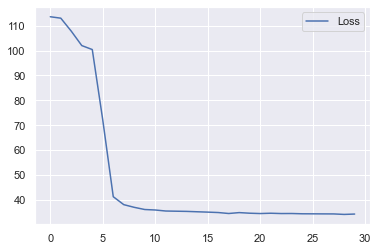

In [28]:
#plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [29]:
# make a prediction using the testing data
y_test_pre=model.predict(x_test, batch_size = 20)
# check length
y_test_pre.shape,y_test.shape

((34305, 1), (34305,))

In [23]:
y_test_pre

array([[ 28.31238 ],
       [ 35.422043],
       [ 26.917326],
       ...,
       [124.02545 ],
       [186.48053 ],
       [246.56583 ]], dtype=float32)

In [30]:
y_test_pre

array([[ 28.31238 ],
       [ 35.422043],
       [ 26.917326],
       ...,
       [124.02545 ],
       [186.48053 ],
       [246.56583 ]], dtype=float32)

In [31]:
pa=pd.DataFrame()
pa['Week']=X_test.reset_index().Week.iloc[1:-1]
pa['County']=X_test.reset_index().county.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.tail(10)

,Week,County,Prediction,Actual Values
34295,76,24510,33.108509,43.5
34296,77,24510,21.293175,31.0
34297,78,24510,15.624335,25.0
34298,79,24510,4.266328,13.0
34299,80,24510,23.681482,33.5
34300,81,24510,20.390173,30.0
34301,82,24510,56.356487,68.0
34302,83,24510,124.025452,139.5
34303,84,24510,186.480530,205.5
34304,85,24510,246.565826,269.0


In [32]:
pa.sample(10)

,Week,County,Prediction,Actual Values
25612,80,6065,142.659088,150.0
4495,77,42133,28.719669,47.5
15535,84,45025,33.697693,54.0
15785,79,45055,0.001565,2.0
9280,85,51650,134.838531,164.5
14529,81,12085,170.833069,182.5
13135,81,20009,6.318635,13.0
3025,86,42015,0.001565,15.0
21711,72,5027,1.214541,0.0
26375,78,47075,0.001565,-2.0


Next step is to do a groupby based on county and figure out the total root MSE for each county. Then plot this. 

add weeks 1-70 into the dataframe

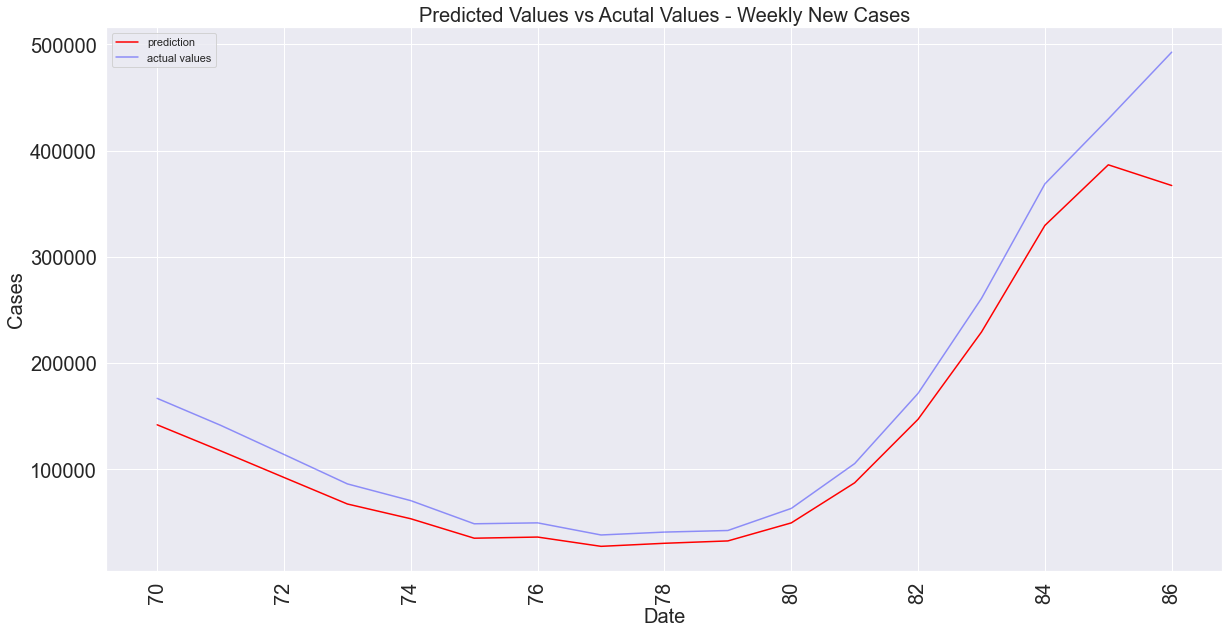

In [25]:
plt.figure(figsize=(20,10))
pa.groupby('Week')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby('Week')['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Cases',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values vs Acutal Values - Weekly New Cases',fontsize=20)
plt.legend()

In [26]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [27]:
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

65.60110643026078


## **Graphing Results**